In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [6]:
dataset = 'cassins'
dims = (32,32,1)
n_components = 64

In [7]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

syllable_df = pd.read_pickle(DATA_DIR/'cassins'/ 'cassins.pickle')



top_labels = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels.values == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:20]
    .T
)

syllable_df = syllable_df[syllable_df.labels.isin(top_labels.columns)]

syllable_df[:3]
syllable_df = syllable_df.reset_index()

syllable_df['subset'] = 'train'
syllable_df.loc[:1000, 'subset'] = 'valid'
syllable_df.loc[1000:1999, 'subset'] = 'test'

specs = np.array(list(syllable_df.spectrogram.values))
specs = np.array([np.concatenate([np.zeros((32,1)), i], axis=1) for i in tqdm(specs)])


syllable_df['spectrogram'] = syllable_df['spectrogram'].astype('object')
syllable_df['spectrogram'] = list(specs)


Y_train = np.array(list(syllable_df.labels.values[syllable_df.subset == 'train']))
Y_valid = np.array(list(syllable_df.labels.values[syllable_df.subset == 'valid']))
Y_test = np.array(list(syllable_df.labels.values[syllable_df.subset == 'test']))

X_train = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'train'])) #/ 255.
X_valid = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'valid']))# / 255.
X_test = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'test'])) #/ 255.

X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
Y_train = enc.fit_transform([[i] for i in Y_train]).astype('int').flatten()
Y_test = enc.fit_transform([[i] for i in Y_test]).astype('int').flatten()
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

### define networks

In [8]:
from tensorflow.keras.layers import (
    Conv2D,
    Reshape,
    Bidirectional,
    Dense,
    RepeatVector,
    TimeDistributed,
    LSTM
)

In [9]:
#shape_final = (8,2,128)

In [10]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu, padding="same"
    ),
    Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu, padding="same"
    ),
    Conv2D(
        filters=128, kernel_size=3, strides=(2, 1), activation=tf.nn.leaky_relu, padding="same"
    ),
    Conv2D(
        filters=128, kernel_size=3, strides=(2, 1), activation=tf.nn.leaky_relu, padding="same"
    ),
    Reshape(target_shape=(8, 2*128)),
    Bidirectional(LSTM(units=100, activation="relu")),
    Dense(units=512),
    Dense(units=n_components),
])

W0822 10:08:42.382573 140500752308032 recurrent_v2.py:1098] Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
W0822 10:08:42.387919 140500752308032 recurrent_v2.py:1098] Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
W0822 10:08:42.394129 140500752308032 recurrent_v2.py:1098] Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


In [11]:
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
    Dense(units=512),
    RepeatVector(8),
    Bidirectional(LSTM(units=100, activation="relu", return_sequences=True)),
    TimeDistributed(Dense(2*128)),
    Reshape(target_shape=(8,2,128)),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(1, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(1, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
    Reshape(target_shape=(32, 32, 1)),
])

W0822 10:08:42.579793 140500752308032 recurrent_v2.py:1098] Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
W0822 10:08:42.584426 140500752308032 recurrent_v2.py:1098] Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
W0822 10:08:42.588807 140500752308032 recurrent_v2.py:1098] Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


In [12]:
input_img = tf.keras.Input(dims)
output_img = decoder(encoder(input_img))
autoencoder = tf.keras.Model(input_img, output_img)

In [13]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [14]:
X_train = X_train.reshape([len(X_train)] + list(dims))
history = autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                #validation_data=(X_valid, X_valid)
                         )

Epoch 1/50
98/98 [==============================] - 5s 54ms/step - loss: 0.2513
Epoch 2/50
98/98 [==============================] - 5s 54ms/step - loss: 0.1249
Epoch 3/50
98/98 [==============================] - 5s 55ms/step - loss: 0.1209
Epoch 4/50
98/98 [==============================] - 5s 55ms/step - loss: 0.1164
Epoch 5/50
98/98 [==============================] - 5s 55ms/step - loss: 0.1123
Epoch 6/50
98/98 [==============================] - 5s 55ms/step - loss: 0.1085
Epoch 7/50
98/98 [==============================] - 5s 55ms/step - loss: 0.1056
Epoch 8/50
98/98 [==============================] - 5s 54ms/step - loss: 0.1034
Epoch 9/50
98/98 [==============================] - 5s 55ms/step - loss: 0.1019
Epoch 10/50
98/98 [==============================] - 5s 55ms/step - loss: 0.1009
Epoch 11/50
98/98 [==============================] - 5s 53ms/step - loss: 0.1002
Epoch 12/50
98/98 [==============================] - 5s 54ms/step - loss: 0.0996
Epoch 13/50
98/98 [==================

In [15]:
z = encoder.predict(X_train)

### Plot model output

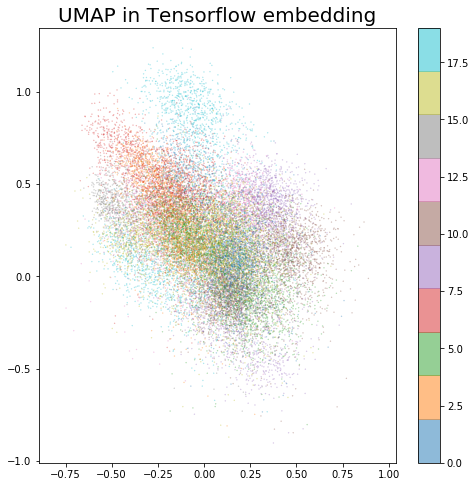

In [16]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)].flatten(),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [17]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

### Save output

In [18]:
dataset = "cassins_dtw"

In [19]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [20]:
output_dir = MODEL_DIR/'projections'/ dataset / '64' / 'ae_only'
ensure_dir(output_dir)

In [21]:
encoder.save(output_dir / 'encoder')

W0822 10:13:26.620363 140500752308032 deprecation.py:323] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
W0822 10:13:26.635676 140500752308032 deprecation.py:323] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
I0822 10:13:28.876913 140500752308032 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/6

In [22]:
decoder.save(output_dir / 'encoder')

I0822 10:13:32.973064 140500752308032 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/64/ae_only/encoder/assets


In [23]:
#loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [24]:
np.save(output_dir / 'z.npy', z)

### compute metrics 

In [25]:
X_test.shape

(1000, 32, 32)

In [26]:
z_test = encoder.predict(X_test.reshape((len(X_test), 32,32,1)))

In [63]:
z_test.shape

(1000, 64)

#### silhouette

In [27]:
from tfumap.silhouette import silhouette_score_block

In [28]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

0.24113584504526303

In [29]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

0.30878646268446913

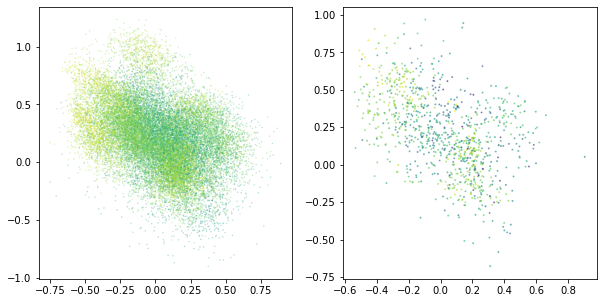

In [30]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train.flatten())
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.993

In [33]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.995

#### Trustworthiness

In [34]:
from sklearn.manifold import trustworthiness

In [35]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [36]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [37]:
tw, tw_test

(0.9980533066453162, 0.9960649193548388)

### Save output metrics

In [38]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

#### train

In [39]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, 'ae_only', n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,cassins_dtw,ae_only,64,0.998053,0.241136,"[0.4015150984260364, 0.1890209511307578, 0.250..."


In [40]:
save_loc = DATA_DIR / 'projection_metrics' /  'ae_only' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### test

In [41]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, 'ae_only', n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,cassins_dtw,ae_only,64,0.996065,0.308786,"[0.26287344824400766, 0.4702562591689133, 0.35..."


In [42]:
save_loc = DATA_DIR / 'projection_metrics' / 'ae' / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### knn 

In [43]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = ['ae_only', n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,ae_only,64,cassins_dtw,0.995,0.993


In [44]:
save_loc = DATA_DIR / 'knn_classifier' / 'ae_only' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)

### Reconstruction

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

In [46]:
X_recon = decoder.predict(encoder.predict(X_test.reshape((len(X_test), 32, 32, 1))))
X_real = X_test.reshape((len(X_test), 32, 32, 1))

In [47]:
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

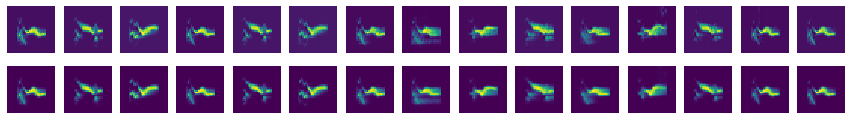

In [60]:
nex = 15
fig, axs = plt.subplots(ncols = nex, nrows=2, figsize=(nex, 2))
for i in np.arange(nex):
    axs[0,i].matshow(np.squeeze(X_real[i]))
    axs[0,i].axis('off')
    axs[1,i].matshow(np.squeeze(X_recon[i]))
    axs[1,i].axis('off')

In [48]:
reconstruction_acc_df = pd.DataFrame(
    columns=["method_", "dimensions", "dataset", "MSE", "MAE", "MedAE", "R2"]
)

In [49]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['ae_only', 64, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,ae_only,64,cassins_dtw,0.00109,0.011767,0.006404,-46771.42396


In [50]:
save_loc = DATA_DIR / 'reconstruction_acc' / 'ae_only' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
reconstruction_acc_df.to_pickle(save_loc)

### Compute clustering quality

In [51]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure

In [52]:
def get_cluster_metrics(row, n_init=5):
    
    # load cluster information
    save_loc = DATA_DIR / 'clustering_metric_df'/ ('_'.join([row.class_, str(row.dim), row.dataset]) + '.pickle')
    print(save_loc)
    if save_loc.exists() and save_loc.is_file():
        
        cluster_df = pd.read_pickle(save_loc)
        return cluster_df
    
    # make cluster metric dataframe
    cluster_df = pd.DataFrame(
        columns=[
            "dataset",
            "class_",
            "dim",
            "silhouette",
            "homogeneity",
            "completeness",
            "v_measure",
            "init_",
            "n_clusters",
            "model",
        ]
    )
    y = row.train_label
    z = row.train_z
    n_labels = len(np.unique(y))
    for n_clusters in tqdm(np.arange(n_labels - int(n_labels / 2), n_labels + int(n_labels / 2)), leave=False, desc = 'n_clusters'):
        for init_ in tqdm(range(n_init), leave=False, desc='init'):
            kmeans = KMeans(n_clusters=n_clusters, random_state=init_).fit(z)
            clustered_y = kmeans.labels_
            homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(
                y, clustered_y
            )
            ss, _ = silhouette_score_block(z, clustered_y)
            cluster_df.loc[len(cluster_df)] = [
                row.dataset,
                row.class_,
                row.dim,
                ss,
                homogeneity,
                completeness,
                v_measure,
                init_,
                n_clusters,
                kmeans,
            ]
    
     # save cluster df in case this fails somewhere
    ensure_dir(save_loc)
    cluster_df.to_pickle(save_loc)
    return cluster_df

In [53]:
n_components

64

In [54]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label', 'dim'])
projection_df.loc[len(projection_df)] = [dataset, 'ae_only', z, Y_train.flatten(), n_components]
projection_df

,dataset,class_,train_z,train_label,dim
0,cassins_dtw,ae_only,"[[-0.361136, 0.29556525, -0.0597352, -0.068110...","[14, 11, 11, 11, 11, 11, 11, 11, 11, 17, 0, 0,...",64


In [55]:
get_cluster_metrics(projection_df.iloc[0], n_init=5)

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/clustering_metric_df/ae_only_64_cassins_dtw.pickle


,dataset,class_,dim,silhouette,homogeneity,completeness,v_measure,init_,n_clusters,model
0,cassins_dtw,ae_only,64,0.239766,0.528899,0.717887,0.609069,0,10,"KMeans(n_clusters=10, random_state=0)"
1,cassins_dtw,ae_only,64,0.239758,0.528782,0.717735,0.608937,1,10,"KMeans(n_clusters=10, random_state=1)"
2,cassins_dtw,ae_only,64,0.239750,0.529186,0.718126,0.609346,2,10,"KMeans(n_clusters=10, random_state=2)"
3,cassins_dtw,ae_only,64,0.239771,0.528889,0.717889,0.609063,3,10,"KMeans(n_clusters=10, random_state=3)"
4,cassins_dtw,ae_only,64,0.238049,0.520991,0.713845,0.602358,4,10,"KMeans(n_clusters=10, random_state=4)"
...,...,...,...,...,...,...,...,...,...,...
95,cassins_dtw,ae_only,64,0.303934,0.799903,0.727098,0.761765,0,29,"KMeans(n_clusters=29, random_state=0)"
96,cassins_dtw,ae_only,64,0.304286,0.799666,0.726793,0.761490,1,29,"KMeans(n_clusters=29, random_state=1)"
97,cassins_dtw,ae_only,64,0.309223,0.789674,0.726216,0.756617,2,29,"KMeans(n_clusters=29, random_state=2)"
98,cassins_dtw,ae_only,64,0.304278,0.796568,0.727415,0.760423,3,29,"KMeans(n_clusters=29, random_state=3)"
